# Algoritmo Genético para resolver un TSP

Probando con 100 puntos. Cuanto nos tardaríamos?

In [1]:
#Importar librerias

import random
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial.distance import cdist
from ortools.linear_solver import pywraplp
import time

load c:\Users\josek\Desktop\ProyectosPersonales\InvestigacionOperativa\.venv\Lib\site-packages\ortools\.libs\zlib1.dll...
load c:\Users\josek\Desktop\ProyectosPersonales\InvestigacionOperativa\.venv\Lib\site-packages\ortools\.libs\abseil_dll.dll...
load c:\Users\josek\Desktop\ProyectosPersonales\InvestigacionOperativa\.venv\Lib\site-packages\ortools\.libs\utf8_validity.dll...
load c:\Users\josek\Desktop\ProyectosPersonales\InvestigacionOperativa\.venv\Lib\site-packages\ortools\.libs\re2.dll...
load c:\Users\josek\Desktop\ProyectosPersonales\InvestigacionOperativa\.venv\Lib\site-packages\ortools\.libs\libprotobuf.dll...
load c:\Users\josek\Desktop\ProyectosPersonales\InvestigacionOperativa\.venv\Lib\site-packages\ortools\.libs\highs.dll...
load c:\Users\josek\Desktop\ProyectosPersonales\InvestigacionOperativa\.venv\Lib\site-packages\ortools\.libs\ortools.dll...


In [2]:
def create_2d_points_df(n, seed):
  """
  Genera n puntos en un espacio 2D y los guarda en un dataframe de pandas.

  Args:
    n: número de puntos
    seed: semilla aleatoria usada para por hacer reproducible el código

  Returns:
    Un dataframe de Pandas con las columnas "x", e "y".
  """
  points_data = []
  random.seed(seed)
  for i in range(n):
    x = random.uniform(-100, 100)
    y = random.uniform(-100, 100)
    points_data.append({'x': x, 'y': y})

  df = pd.DataFrame(points_data)
  return df


def calculate_distance(df):
  """
 Toma un dataframe con columnas 'x' e 'y' y calcula las distancias euclídeas

  Args:
    df: dataframe de pandas con columnas 'x' e 'y'.

  Returns:
    Una matriz de distancias euclídeas.
  """
  coords = df[['x', 'y']].values
  distance_matrix = cdist(coords, coords, metric='euclidean')
  return distance_matrix

def plot_points(df):
  """
  Plotea los puntos generados por create_2d_points_df.

  Args:
    df: df: dataframe de pandas con columnas 'x' e 'y'.
  """
  x_coords = df['x'].tolist()
  y_coords = df['y'].tolist()

  plt.figure(figsize=(8, 8))
  plt.scatter(x_coords, y_coords)
  plt.title('Puntos en el espacio 2D')
  plt.xlabel('X')
  plt.ylabel('Y')
  plt.grid(True)
  plt.show()


def points_sub(points, i):
    """
    De una lista de numeros sustrae el numero i en una copia nueva.
    Se considera que poinla lista no tiene elementos duplicados (por ser lista de indices) y que i se encuentra en la lista.

    Args:
      points: lista de puntos.
      i: elemento a sustraer de la lista

    Returns:
      new: lista nueva similar a points pero sin el elemento i.
    """
    new = points.copy()
    new.remove(i)
    return new

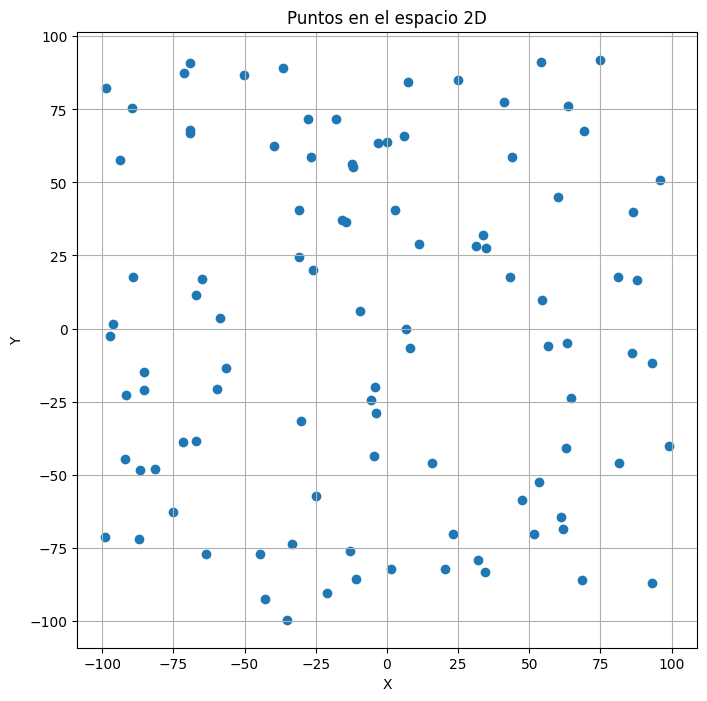

In [3]:
# Defino una semilla
seed = 1234

# Genero los puntos
puntos = create_2d_points_df(100, seed)

# Ploteo los puntos
plot_points(puntos)

# Calculo distancias
distancias = calculate_distance(puntos)

In [5]:
# Definimos el modelo
modelo_mtz = pywraplp.Solver.CreateSolver('SAT')

list_index_puntos = list(puntos.index)

# uso n como n-1 ya que arranco de indice 0 en la lista. Por esto en mtz no resto 1 ni en u_i
n = max(list_index_puntos)

# Definimos variables

x_ij={i:{j: modelo_mtz.IntVar(0,1,'x_'+str(i)+'_'+str(j)) for j in points_sub(list_index_puntos, i)} for i in list_index_puntos}
u_i = {i: modelo_mtz.IntVar(1,n,'u_'+str(i)) for i in points_sub(list_index_puntos, 0)}

# Definimos la función objetivo
obj_expr = sum(x_ij[i][j] * distancias[i][j] for i in list_index_puntos for j in points_sub(list_index_puntos, i))


#Restricciones:

#1
for j in list_index_puntos:
    modelo_mtz.Add(sum(x_ij[i][j] for i in points_sub(list_index_puntos, j)) == 1)

#2
for i in list_index_puntos:
    modelo_mtz.Add(sum(x_ij[i][j] for j in points_sub(list_index_puntos, i)) == 1)

#3
for i in points_sub(list_index_puntos, 0):
    for j in points_sub(points_sub(list_index_puntos, 0), i):
        modelo_mtz.Add(u_i[i] - u_i[j] + 1 <= n * (1- x_ij[i][j]))


# Solver
modelo_mtz.Minimize(obj_expr)

In [6]:
inicio = time.time()
status = modelo_mtz.Solve()
fin = time.time()
print("Tiempo de ejecución:", fin - inicio, "segundos")

Tiempo de ejecución: 697.2730700969696 segundos


In [7]:
if status == pywraplp.Solver.OPTIMAL:
    print("Costo total:", modelo_mtz.Objective().Value())
else:
    print("No se encontró solución óptima.")

Costo total: 1530.4892402519954


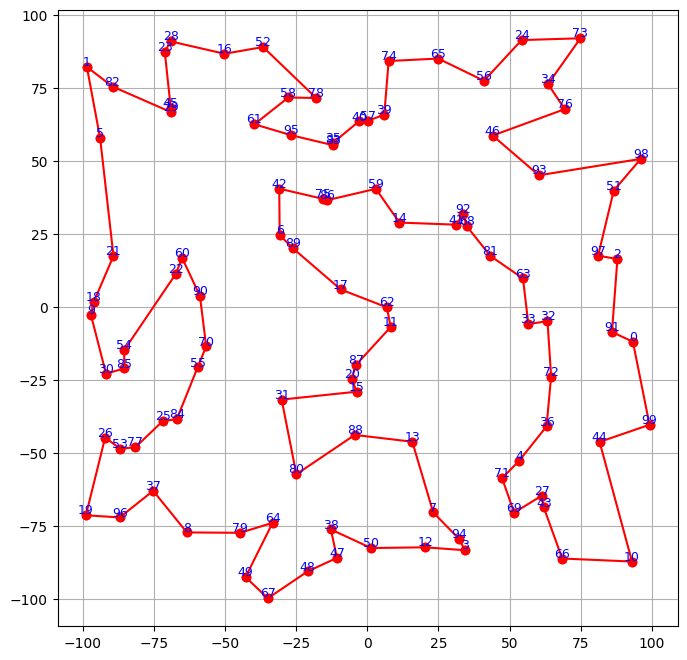

In [8]:
plt.figure(figsize=(8, 8))
plt.grid(True)
for i in list_index_puntos:
    for j in points_sub(list_index_puntos, i):
        if x_ij[i][j].SolutionValue() == 1:
            plt.plot(puntos.iloc[[i,j]]['x'], puntos.iloc[[i,j]]['y'], 'ro-')
            plt.text(puntos.iloc[i]['x'], puntos.iloc[i]['y'] + 0.5, str(i), ha='center', fontsize=9, color='blue')    
plt.show()

Esta ejecución llevó casi 12 minutos, con un costo mínimo encontrado de 1530.4892402519954

Y si usamos un algoritmo genético?

Para comenzar, generamos un subset de cadenas iniciales, donde tomamos como partida el 0 y luego tenemos los demás puntos elegidos de una forma aleatoria.

In [4]:
def secuencia_random(puntos, seed, cantidad=10):
    """
    Genera una secuencia aleatoria de indices de puntos.

    Args:
      puntos: dataframe de pandas con columnas 'x' e 'y'.
      seed: semilla aleatoria usada para por hacer reproducible el código

    Returns:
      Una lista con una secuencia aleatoria de indices de puntos.
    """
    secuencia = []
    for i in list(range(cantidad)):
      random.seed(seed + i)
      lista_indices = list(puntos.index)
      lista_indices = lista_indices[1:]
      random.shuffle(lista_indices)
      lista_indices = [0] + lista_indices
      secuencia.append(lista_indices)
      
    return secuencia

In [5]:
secs = secuencia_random(puntos, 42, cantidad=30)

In [6]:
def calcular_distancia_total(secuencia, distancias):
    """
    Calcula la distancia total de una secuencia de indices de puntos.

    Args:
      secuencia: lista con una secuencia de indices de puntos.
      distancias: matriz de distancias euclídeas.

    Returns:
      La distancia total de la secuencia.
    """
    distancia_total = 0
    for i in range(len(secuencia) - 1):
        distancia_total += distancias[secuencia[i]][secuencia[i + 1]]
    distancia_total += distancias[secuencia[-1]][secuencia[0]]  # Volver al punto inicial
    return distancia_total

In [7]:
for i in range(len(secs)):
    print(f"Distancia total de la secuencia {i+1}: {calcular_distancia_total(secs[i], distancias)}")

Distancia total de la secuencia 1: 10218.796399795056
Distancia total de la secuencia 2: 10526.596981415856
Distancia total de la secuencia 3: 10569.995765383479
Distancia total de la secuencia 4: 10378.727453419731
Distancia total de la secuencia 5: 10730.408896810302
Distancia total de la secuencia 6: 10947.413080477532
Distancia total de la secuencia 7: 10661.179800205691
Distancia total de la secuencia 8: 11027.207162627643
Distancia total de la secuencia 9: 10842.510434982669
Distancia total de la secuencia 10: 10547.419645117196
Distancia total de la secuencia 11: 10285.326102046161
Distancia total de la secuencia 12: 9940.688702058887
Distancia total de la secuencia 13: 10565.102816584173
Distancia total de la secuencia 14: 10352.09913238319
Distancia total de la secuencia 15: 10470.021346625126
Distancia total de la secuencia 16: 11420.975156738752
Distancia total de la secuencia 17: 10711.155973823054
Distancia total de la secuencia 18: 11331.881442543954
Distancia total de la

creo una funcion para mutar secuencias

In [11]:
def mutar_secuencia(secuencia, seed):
    """ 
    Mutar una secuencia de indices de puntos intercambiando dos puntos aleatoriamente.

    Args:
      secuencia: lista con una secuencia de indices de puntos.
      seed: semilla aleatoria usada para por hacer reproducible el código

    Returns:
      Una nueva secuencia mutada.
    """
    random.seed(seed)
    nueva_secuencia = secuencia.copy()
    idx1, idx2 = random.sample(range(1, len(secuencia)), 2)  # Evitar el primer punto (índice 0)
    nueva_secuencia[idx1], nueva_secuencia[idx2] = nueva_secuencia[idx2], nueva_secuencia[idx1]
    return nueva_secuencia

creo una funcion para realizar el proceso evolutivo

In [12]:
def proceso_evolutivo(distancias, poblacion_inicial, generaciones, tasa_mutacion, seed):
    """
    Implementa un proceso evolutivo para optimizar la secuencia de puntos.

    Args:
      distancias: matriz de distancias euclídeas.
      poblacion_inicial: lista de listas con secuencias iniciales de indices de puntos.
      generaciones: número de generaciones a ejecutar.
      tasa_mutacion: probabilidad de mutación para cada secuencia.
      seed: semilla aleatoria usada para por hacer reproducible el código

    Returns:
      La mejor secuencia encontrada y su distancia total.
    """
    poblacion = poblacion_inicial.copy()
    mejor_secuencia = None
    mejor_distancia = float('inf')

    for gen in range(generaciones):
        nuevas_secuencias = []
        for secuencia in poblacion:
            # if random.random() < tasa_mutacion:
            #     secuencia_mutada = mutar_secuencia(secuencia, seed + gen)
            #     nuevas_secuencias.append(secuencia_mutada)
            # else:
            #     nuevas_secuencias.append(secuencia)
            
            secuencia_mutada = mutar_secuencia(secuencia, seed + gen) #hago que se muten todas las secuencias
            nuevas_secuencias.append(secuencia_mutada)
            

        poblacion = nuevas_secuencias

        for secuencia in poblacion:
            distancia = calcular_distancia_total(secuencia, distancias)
            if distancia < mejor_distancia:
                mejor_distancia = distancia
                mejor_secuencia = secuencia

    return mejor_secuencia, mejor_distancia

In [66]:
inicio = time.time()
mejor_secuencia, mejor_distancia = proceso_evolutivo(distancias, secs, generaciones=100000, tasa_mutacion=1, seed=42)
fin = time.time()
print("Tiempo de ejecución:", fin - inicio, "segundos")
print("Mejor secuencia encontrada:", mejor_secuencia)
print("Distancia total de la mejor secuencia:", mejor_distancia)

Tiempo de ejecución: 63.504587173461914 segundos
Mejor secuencia encontrada: [0, 33, 51, 8, 38, 30, 26, 43, 5, 70, 96, 82, 95, 36, 27, 55, 94, 77, 31, 84, 12, 44, 15, 29, 79, 67, 6, 21, 50, 39, 24, 57, 45, 1, 65, 58, 35, 76, 99, 69, 32, 88, 3, 54, 25, 89, 7, 75, 13, 81, 63, 60, 14, 4, 46, 66, 64, 19, 17, 83, 34, 2, 61, 49, 10, 18, 37, 90, 74, 78, 42, 68, 16, 52, 40, 23, 73, 56, 92, 86, 59, 20, 71, 93, 41, 53, 9, 85, 91, 72, 22, 28, 62, 47, 11, 48, 80, 87, 98, 97]
Distancia total de la mejor secuencia: 8365.86089350857


Este proceso tiene dos problemas. El primero es que se repiten muchas semillas, lo que no ayuda a la mezcla aleatoria. Por otro lado, si ya teniamos una secuencia buena y es mutada por una peor, empeora. Lo que se propone es afectar la seed multiplicativamente y además, evaluar cuál de las dos secuencias es la mejor, la original o la mutada, y se guarda la ganadora.

In [13]:
def proceso_evolutivo_mejorado(distancias, poblacion_inicial, generaciones, tasa_mutacion, seed):
    """
    Implementa un proceso evolutivo para optimizar la secuencia de puntos.

    Args:
      distancias: matriz de distancias euclídeas.
      poblacion_inicial: lista de listas con secuencias iniciales de indices de puntos.
      generaciones: número de generaciones a ejecutar.
      tasa_mutacion: probabilidad de mutación para cada secuencia.
      seed: semilla aleatoria usada para por hacer reproducible el código

    Returns:
      La mejor secuencia encontrada y su distancia total.
    """
    poblacion = poblacion_inicial.copy()
    mejor_secuencia = None
    mejor_distancia = float('inf')

    for gen in range(generaciones):
        nuevas_secuencias = []
        factor = 0
        for secuencia in poblacion:
            factor += 1
            # if random.random() < tasa_mutacion:
            #     secuencia_mutada = mutar_secuencia(secuencia, seed + gen)
            #     nuevas_secuencias.append(secuencia_mutada)
            # else:
            #     nuevas_secuencias.append(secuencia)
            
            secuencia_mutada = mutar_secuencia(secuencia, seed * gen * factor)
            distancia_mutada = calcular_distancia_total(secuencia_mutada, distancias)
            distancia_original = calcular_distancia_total(secuencia, distancias)
            if distancia_mutada < distancia_original:
              nuevas_secuencias.append(secuencia_mutada)
            else:
              nuevas_secuencias.append(secuencia)

        poblacion = nuevas_secuencias
        
    # lo muevo al final total siempre llegan las mismas secuencias y para no recalcular tantas veces
    for secuencia in poblacion:
        distancia = calcular_distancia_total(secuencia, distancias)
        if distancia < mejor_distancia:
            mejor_distancia = distancia
            mejor_secuencia = secuencia

    return mejor_secuencia, mejor_distancia

In [11]:
inicio = time.time()
mejor_secuencia, mejor_distancia = proceso_evolutivo_mejorado(distancias, secs, generaciones=100000, tasa_mutacion=1, seed=42)
fin = time.time()
print("Tiempo de ejecución:", fin - inicio, "segundos")
print("Mejor secuencia encontrada:", mejor_secuencia)
print("Distancia total de la mejor secuencia:", mejor_distancia)

Tiempo de ejecución: 114.24502682685852 segundos
Mejor secuencia encontrada: [0, 91, 72, 36, 62, 17, 90, 61, 52, 16, 29, 60, 22, 54, 85, 30, 25, 84, 55, 70, 11, 33, 32, 76, 73, 24, 34, 93, 92, 59, 35, 83, 86, 75, 89, 6, 95, 58, 78, 40, 57, 39, 74, 65, 56, 46, 68, 41, 14, 42, 45, 23, 28, 1, 82, 5, 21, 18, 9, 26, 53, 77, 37, 64, 48, 80, 31, 87, 20, 15, 88, 38, 50, 12, 7, 94, 3, 69, 27, 43, 66, 10, 99, 44, 4, 71, 19, 96, 8, 79, 49, 67, 47, 13, 81, 63, 97, 51, 98, 2]
Distancia total de la mejor secuencia: 2386.0047256498474


En menos de 2 minutos, conseguimos una muy buena primera aproximación

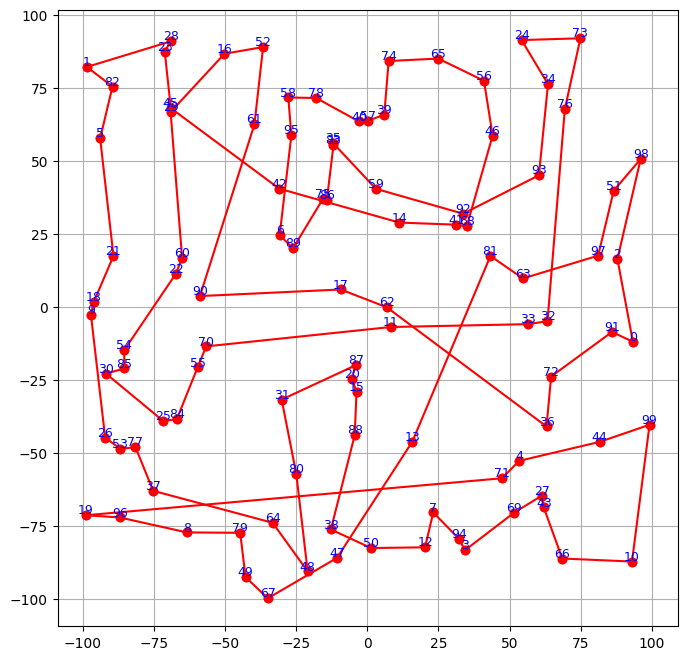

In [12]:
plt.figure(figsize=(8, 8))
plt.grid(True)
for i in range(len(mejor_secuencia)):
    j = (i + 1) % len(mejor_secuencia)
    plt.plot(puntos.iloc[[mejor_secuencia[i], mejor_secuencia[j]]]['x'], puntos.iloc[[mejor_secuencia[i], mejor_secuencia[j]]]['y'], 'ro-')
    plt.text(puntos.iloc[mejor_secuencia[i]]['x'], puntos.iloc[mejor_secuencia[i]]['y'] + 0.5, str(mejor_secuencia[i]), ha='center', fontsize=9, color='blue')

Claramente, aún falta mejorar. Pero llegamos a un resultado más que aceptable.

Vamos a evaluar a continuación, como cambia el resultado a medida que agregamos más generaciones

In [31]:
def show_secuencia_evolucion(dic_distancias, puntos):
    """
    Muestra la evolución de la secuencia de puntos a lo largo de las generaciones.

    Args:
      dic_distancias: diccionario con claves como generaciones y valores como tuplas (secuencia, distancia).
      puntos: dataframe de pandas con columnas 'x' e 'y'.
    """
    import matplotlib.pyplot as plt

    from IPython.display import clear_output

    # Parameters
    generaciones_plot = sorted(dic_distancias.keys())
    pause_secs = 0.1  # tiempo entre frames (ajustable)

    # fijo límites para evitar zoom entre frames
    xmin, xmax = puntos['x'].min(), puntos['x'].max()
    ymin, ymax = puntos['y'].min(), puntos['y'].max()
    xpad = (xmax - xmin) * 0.05
    ypad = (ymax - ymin) * 0.05

    for gen in generaciones_plot:
        seq = list(dic_distancias[gen][0])  # secuencia en ese checkpoint
        # preparar secuencia cerrada
        seq_loop = seq + [seq[0]]

        clear_output(wait=True)  # borra el plot anterior en la salida de la celda
        plt.figure(figsize=(8, 8))
        plt.title(f"Generación {gen} — Distancia: {float(dic_distancias[gen][1]):.2f}")
        plt.scatter(puntos['x'], puntos['y'], s=20, color='black')

        # dibujar la ruta
        xs = puntos.loc[seq_loop, 'x'].values
        ys = puntos.loc[seq_loop, 'y'].values
        plt.plot(xs, ys, 'ro-', linewidth=1, markersize=4)

        # opcional: numerar en cada punto el orden en la secuencia (pequeño)
        for order, idx in enumerate(seq):
            plt.text(puntos.at[idx, 'x'], puntos.at[idx, 'y'] + 0.6, str(order), 
                    ha='center', fontsize=7, color='blue')

        plt.xlim(xmin - xpad, xmax + xpad)
        plt.ylim(ymin - ypad, ymax + ypad)
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        plt.pause(pause_secs)

    # dejar el último plot visible (ya lo está tras el loop)

In [15]:
def proceso_evolutivo_mejorado_historial(distancias, poblacion_inicial, check_list, seed):
    """
    Implementa un proceso evolutivo para optimizar la secuencia de puntos.

    Args:
      distancias: matriz de distancias euclídeas.
      poblacion_inicial: lista de listas con secuencias iniciales de indices de puntos.
      check_list: lista con el numero de generaciones a evaluar
      tasa_mutacion: probabilidad de mutación para cada secuencia.
      seed: semilla aleatoria usada para por hacer reproducible el código

    Returns:
      La mejor secuencia encontrada y su distancia total.
    """
    generaciones = max(check_list)
    poblacion = poblacion_inicial.copy()
    mejor_secuencia = None
    mejor_distancia = float('inf')
    dic_distancias = {}

    for gen in range(generaciones+1):
        nuevas_secuencias = []
        factor = 0
        for secuencia in poblacion:
            factor += 1
            # if random.random() < tasa_mutacion:
            #     secuencia_mutada = mutar_secuencia(secuencia, seed + gen)
            #     nuevas_secuencias.append(secuencia_mutada)
            # else:
            #     nuevas_secuencias.append(secuencia)
            
            secuencia_mutada = mutar_secuencia(secuencia, seed * gen * factor)
            distancia_mutada = calcular_distancia_total(secuencia_mutada, distancias)
            distancia_original = calcular_distancia_total(secuencia, distancias)
            if distancia_mutada < distancia_original:
              nuevas_secuencias.append(secuencia_mutada)
            else:
              nuevas_secuencias.append(secuencia)

        poblacion = nuevas_secuencias

        if gen in check_list:
            for secuencia in poblacion:
                distancia = calcular_distancia_total(secuencia, distancias)
                if distancia < mejor_distancia:
                    mejor_distancia = distancia
                    mejor_secuencia = secuencia
            dic_distancias[gen] = (mejor_secuencia, mejor_distancia)
        
    # lo muevo al final total siempre llegan las mismas secuencias y para no recalcular tantas veces
    # for secuencia in poblacion:
    #     distancia = calcular_distancia_total(secuencia, distancias)
    #     if distancia < mejor_distancia:
    #         mejor_distancia = distancia
    #         mejor_secuencia = secuencia

    return dic_distancias

In [17]:
check_list = list(range(1000, 500001, 1000))

In [15]:
inicio = time.time()
dic_distancias = proceso_evolutivo_mejorado_historial(distancias, secs, check_list, 42)
fin = time.time()

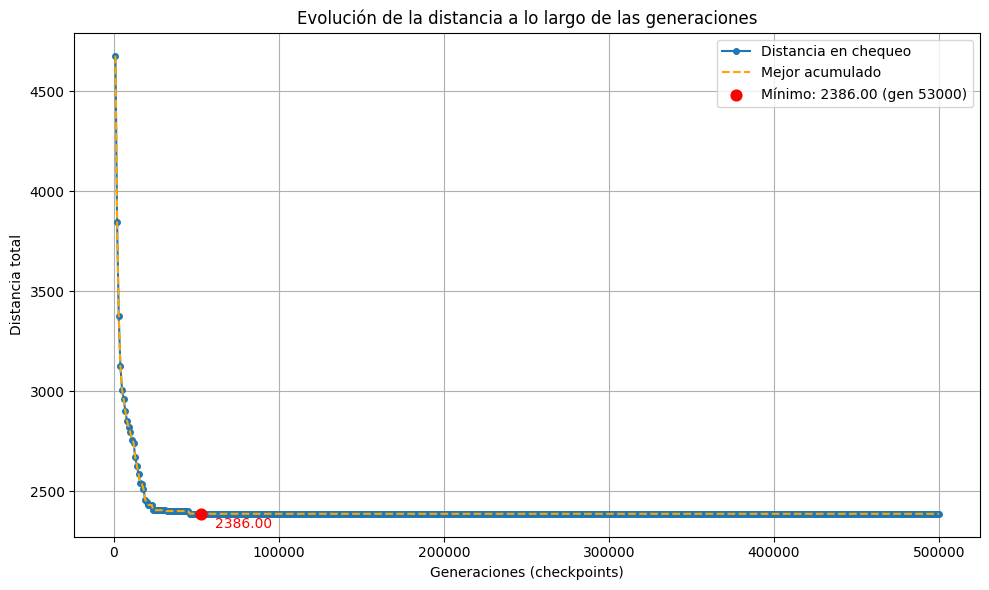

In [17]:
# Plotea la evolución de las distancias guardadas en dic_distancias
generaciones = sorted(dic_distancias.keys())
dist_vals = [float(dic_distancias[g][1]) for g in generaciones]

# Mejor acumulada hasta cada punto (best so far)
best_so_far = []
current_best = float('inf')
for d in dist_vals:
    if d < current_best:
        current_best = d
    best_so_far.append(current_best)

plt.figure(figsize=(10, 6))
plt.plot(generaciones, dist_vals, marker='o', markersize=4, linestyle='-', label='Distancia en chequeo')
plt.plot(generaciones, best_so_far, linestyle='--', color='orange', label='Mejor acumulado')

# Anotar el mejor global
min_idx = min(range(len(dist_vals)), key=lambda i: dist_vals[i])
min_gen = generaciones[min_idx]
min_dist = dist_vals[min_idx]
plt.scatter([min_gen], [min_dist], color='red', s=60, zorder=5, label=f'Mínimo: {min_dist:.2f} (gen {min_gen})')
plt.annotate(f"{min_dist:.2f}", xy=(min_gen, min_dist), xytext=(10, -10), textcoords='offset points', color='red')

plt.xlabel('Generaciones (checkpoints)')
plt.ylabel('Distancia total')
plt.title('Evolución de la distancia a lo largo de las generaciones')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Como vemos, parece ser que no hay mejora significativa una vez pasamos el gen 53000, y sabemos que aún podemos mejorar. Esto podria darse (a checkear) porque estamos trabajando solo sobre un par en secuencia y lo puede hacer restrictivo. Vamos entonces a hacer una ultima prueba, en la cual damos la posibilidad de mutar sobre más de un valor en la secuencia.

In [34]:
def mutar_secuencia_mejorada(secuencia, seed):
    """ 
    Mutar una secuencia de indices de puntos intercambiando dos puntos aleatoriamente.

    Args:
      secuencia: lista con una secuencia de indices de puntos.
      seed: semilla aleatoria usada para por hacer reproducible el código

    Returns:
      Una nueva secuencia mutada.
    """
    random.seed(seed)
    cantidad_max_mutaciones = max(1, len(secuencia) // 20)  # Al menos una mutación
    cantidad_mutaciones = random.randint(1, cantidad_max_mutaciones)
    for _ in range(cantidad_mutaciones):
        seed += 1
        secuencia = mutar_secuencia(secuencia, seed)

    nueva_secuencia = secuencia.copy()
    return nueva_secuencia

In [35]:
def proceso_evolutivo_mejorado_historial_2(distancias, poblacion_inicial, check_list, seed):
    """
    Implementa un proceso evolutivo para optimizar la secuencia de puntos.

    Args:
      distancias: matriz de distancias euclídeas.
      poblacion_inicial: lista de listas con secuencias iniciales de indices de puntos.
      check_list: lista con el numero de generaciones a evaluar
      tasa_mutacion: probabilidad de mutación para cada secuencia.
      seed: semilla aleatoria usada para por hacer reproducible el código

    Returns:
      La mejor secuencia encontrada y su distancia total.
    """
    generaciones = max(check_list)
    poblacion = poblacion_inicial.copy()
    mejor_secuencia = None
    mejor_distancia = float('inf')
    dic_distancias = {}

    for gen in range(generaciones+1):
        nuevas_secuencias = []
        factor = 0
        for secuencia in poblacion:
            factor += 1
            # if random.random() < tasa_mutacion:
            #     secuencia_mutada = mutar_secuencia(secuencia, seed + gen)
            #     nuevas_secuencias.append(secuencia_mutada)
            # else:
            #     nuevas_secuencias.append(secuencia)
            
            secuencia_mutada = mutar_secuencia_mejorada(secuencia, seed * gen * factor)
            distancia_mutada = calcular_distancia_total(secuencia_mutada, distancias)
            distancia_original = calcular_distancia_total(secuencia, distancias)
            if distancia_mutada < distancia_original:
              nuevas_secuencias.append(secuencia_mutada)
            else:
              nuevas_secuencias.append(secuencia)

        poblacion = nuevas_secuencias

        if gen in check_list:
            for secuencia in poblacion:
                distancia = calcular_distancia_total(secuencia, distancias)
                if distancia < mejor_distancia:
                    mejor_distancia = distancia
                    mejor_secuencia = secuencia
            dic_distancias[gen] = (mejor_secuencia, mejor_distancia)
        
    # lo muevo al final total siempre llegan las mismas secuencias y para no recalcular tantas veces
    # for secuencia in poblacion:
    #     distancia = calcular_distancia_total(secuencia, distancias)
    #     if distancia < mejor_distancia:
    #         mejor_distancia = distancia
    #         mejor_secuencia = secuencia

    return dic_distancias

In [36]:
inicio = time.time()
dic_distancias = proceso_evolutivo_mejorado_historial_2(distancias, secs, check_list, 42)
fin = time.time()

In [37]:
print("Tiempo de ejecución:", fin - inicio, "segundos")

Tiempo de ejecución: 862.1956803798676 segundos


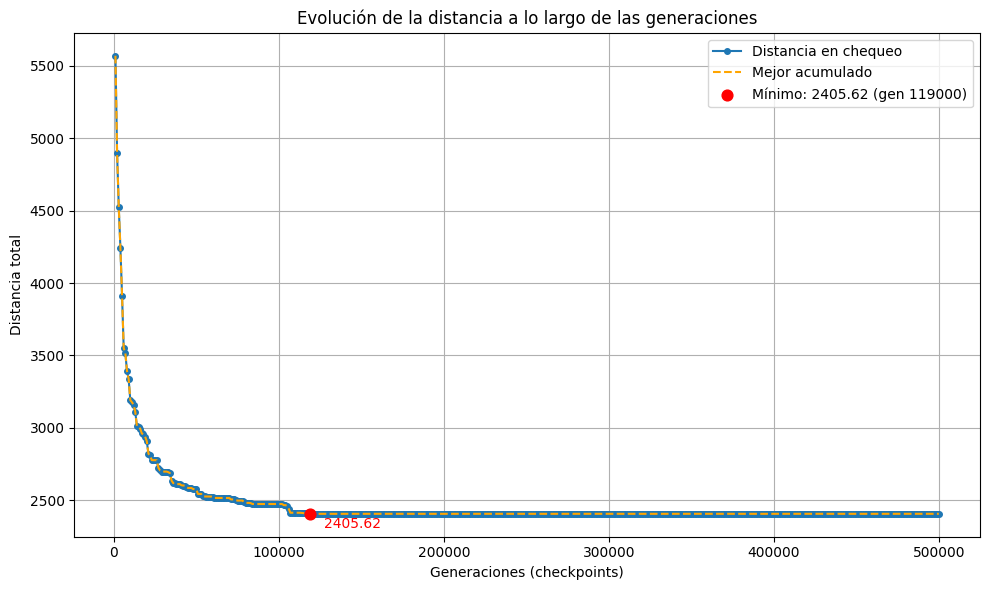

In [39]:
# Plotea la evolución de las distancias guardadas en dic_distancias
generaciones = sorted(dic_distancias.keys())
dist_vals = [float(dic_distancias[g][1]) for g in generaciones]

# Mejor acumulada hasta cada punto (best so far)
best_so_far = []
current_best = float('inf')
for d in dist_vals:
    if d < current_best:
        current_best = d
    best_so_far.append(current_best)

plt.figure(figsize=(10, 6))
plt.plot(generaciones, dist_vals, marker='o', markersize=4, linestyle='-', label='Distancia en chequeo')
plt.plot(generaciones, best_so_far, linestyle='--', color='orange', label='Mejor acumulado')

# Anotar el mejor global
min_idx = min(range(len(dist_vals)), key=lambda i: dist_vals[i])
min_gen = generaciones[min_idx]
min_dist = dist_vals[min_idx]
plt.scatter([min_gen], [min_dist], color='red', s=60, zorder=5, label=f'Mínimo: {min_dist:.2f} (gen {min_gen})')
plt.annotate(f"{min_dist:.2f}", xy=(min_gen, min_dist), xytext=(10, -10), textcoords='offset points', color='red')

plt.xlabel('Generaciones (checkpoints)')
plt.ylabel('Distancia total')
plt.title('Evolución de la distancia a lo largo de las generaciones')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
show_secuencia_evolucion(dic_distancias, puntos)

Ahora lo mismo, pero con más secuencias iniciales

In [8]:
secs = secuencia_random(puntos, 42, cantidad=100)

In [9]:
mejor_distancia = float('inf')
mejor_secuencia = None
for i in range(len(secs)):
    distancia = calcular_distancia_total(secs[i], distancias)
    if distancia < mejor_distancia:
        mejor_distancia = distancia
        mejor_secuencia = secs[i]
print("Mejor secuencia encontrada:", mejor_secuencia)
print("Distancia total de la mejor secuencia:", mejor_distancia)

Mejor secuencia encontrada: [0, 57, 95, 86, 38, 26, 80, 47, 77, 41, 30, 88, 15, 50, 25, 3, 99, 13, 52, 69, 96, 9, 44, 56, 87, 61, 75, 90, 23, 54, 53, 55, 72, 32, 78, 84, 45, 29, 20, 71, 39, 97, 18, 66, 22, 21, 31, 93, 33, 60, 36, 2, 51, 11, 42, 67, 79, 89, 1, 5, 64, 43, 73, 8, 28, 37, 65, 16, 4, 91, 7, 24, 68, 81, 17, 14, 59, 83, 49, 6, 19, 70, 10, 48, 35, 63, 34, 98, 94, 58, 46, 82, 40, 76, 74, 85, 62, 12, 92, 27]
Distancia total de la mejor secuencia: 9587.47213139825


In [18]:
check_list = list(range(1000, 500001, 1000))

In [20]:
inicio = time.time()
dic_distancias = proceso_evolutivo_mejorado_historial(distancias, secs, check_list, 42)
fin = time.time()
print("Tiempo de ejecución:", fin - inicio, "segundos")

Tiempo de ejecución: 1881.873036146164 segundos


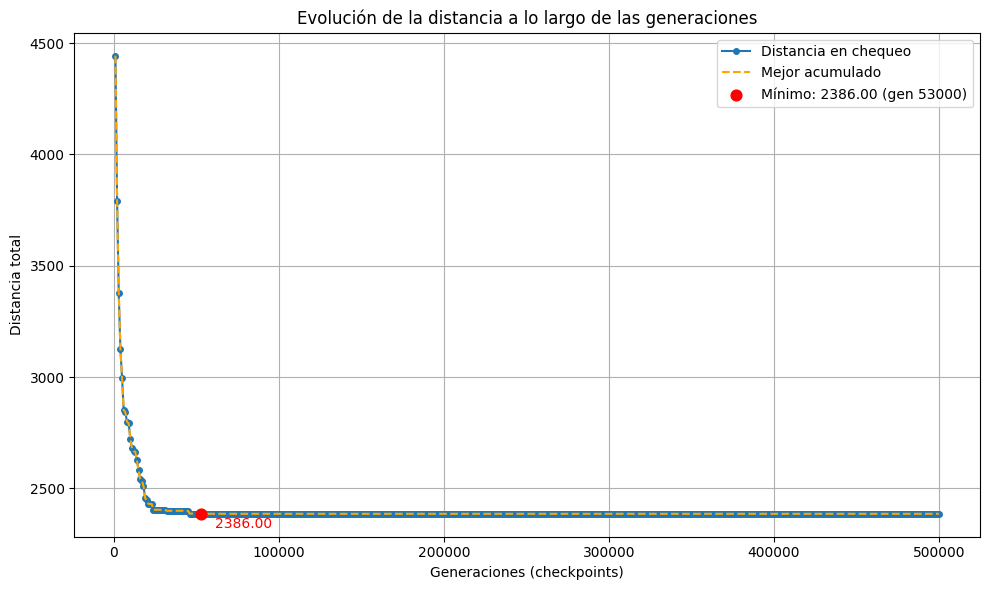

In [21]:
# Plotea la evolución de las distancias guardadas en dic_distancias
generaciones = sorted(dic_distancias.keys())
dist_vals = [float(dic_distancias[g][1]) for g in generaciones]

# Mejor acumulada hasta cada punto (best so far)
best_so_far = []
current_best = float('inf')
for d in dist_vals:
    if d < current_best:
        current_best = d
    best_so_far.append(current_best)

plt.figure(figsize=(10, 6))
plt.plot(generaciones, dist_vals, marker='o', markersize=4, linestyle='-', label='Distancia en chequeo')
plt.plot(generaciones, best_so_far, linestyle='--', color='orange', label='Mejor acumulado')

# Anotar el mejor global
min_idx = min(range(len(dist_vals)), key=lambda i: dist_vals[i])
min_gen = generaciones[min_idx]
min_dist = dist_vals[min_idx]
plt.scatter([min_gen], [min_dist], color='red', s=60, zorder=5, label=f'Mínimo: {min_dist:.2f} (gen {min_gen})')
plt.annotate(f"{min_dist:.2f}", xy=(min_gen, min_dist), xytext=(10, -10), textcoords='offset points', color='red')

plt.xlabel('Generaciones (checkpoints)')
plt.ylabel('Distancia total')
plt.title('Evolución de la distancia a lo largo de las generaciones')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [22]:
show_secuencia_evolucion(dic_distancias, puntos)

NameError: name 'show_secuencia_evolucion' is not defined